## **Introduction:**

The Tunisian Company of Electricity and Gas (STEG) is a public and non-administrative company that is responsible for delivering electricity and gas across Tunisia. The company has suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

A crucial problem that these companies face is the imbalance between the energy billed and the energy delivered. This problem is called energy losses caused by fraud or technical causes like meter malfunctions, pipes damages and other technical issues.

## **SETUP**

In [ ]:
%%capture
!pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, log_loss
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn import preprocessing
import time

from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from catboost import CatBoostClassifier

## **UTILS**

In [ ]:
#Reduce Memory Usage
def reduce_memory_usage(df):
  for col in df.columns:
    col_type = df[col].dtype.name
    if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
      if (col_type != 'object'):
        c_min = df[col].min()
        c_max = df[col].max()

        if str(col_type)[:3] == 'int':
          if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
          elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
          elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
          elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
            df[col] = df[col].astype(np.int64)

        else:
          if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
          elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
          else:
            pass
    else:
      df[col] = df[col].astype('category')
    
  return df

## **CONFIG**

In [ ]:
class CFG:
  seed = 47

In [ ]:
path = "/content/drive/MyDrive/EnergyConsumptionFraudDetection/"

In [ ]:
testInvoices = pd.read_csv(f'{path}test/invoice_test.csv',low_memory=False)
trainInvoices = pd.read_csv(f'{path}train/invoice_train.csv',low_memory=False)
testClient = pd.read_csv(f'{path}test/client_test.csv',low_memory=False)
trainClient = pd.read_csv(f'{path}train/client_train.csv',low_memory=False)

In [ ]:
print("Train invoices: ", trainInvoices.shape)
print("Train clients: ", trainClient.shape, '\n')
print("Test invoices: ", testInvoices.shape)
print("Test clients: ", testClient.shape)

In [ ]:
print('Number of missing rows in Train invoices:',trainInvoices.isna().sum().sum())
print('Number of missing rows in Test invoices:',testInvoices.isna().sum().sum(),'\n')
print('Number of missing rows in Train clients:',trainClient.isna().sum().sum())
print('Number of missing rows in Test clients:',testClient.isna().sum().sum())

In [ ]:
print('Number of unique values in invoice_train:')
for col in trainInvoices.columns:
    print(f"{col}            <=========>                {trainInvoices[col].nunique()}")

In [ ]:
trainClient.head()

In [ ]:
trainInvoices.head()

## **Exploratory data analysis (EDA)**

In [ ]:
trainClient['creation_year'] = pd.to_datetime(trainClient['creation_date'], dayfirst=True).dt.year
years=set(trainClient['creation_year'])

In [ ]:
counterType = trainInvoices['counter_type'].tolist()
counterTypeElec = counterType.count('ELEC')*100 / len(counterType)
counterTypeGaz = counterType.count('GAZ')*100 / len(counterType)
plt.figure(figsize=(6,6))
plt.pie([counterTypeElec, counterTypeGaz], labels = ['Electricity','Gas'],autopct='%1.1f%%')
plt.title("Proportion of Counter type (Electricity to Gas)")
plt.show()

**Observation**
- The plot shows the proportion of counter type (electricity to gas) for the Tunisian Company of Electricity and Gas (STEG). The data shows that 68.8% of counters are for electricity and 31.2% of counters are for gas.



In [ ]:
creationYear = trainClient.groupby(['creation_year'])['client_id'].count()
plt.figure(figsize=(12,3))
plt.plot(creationYear)
plt.title('Number of Clients by Creation Year')
plt.xlabel('Creation Year')
plt.ylabel('Number of Clients')
plt.xticks(range(min(creationYear.index), max(creationYear.index)+1, 5), rotation=45)
plt.show()

**Observation**
- The data shows that the number of clients has increased steadily over the years, with a few notable dips in 1999, 2002, and 2005. The largest increase in the number of clients occurred between 1997 and 2018, with a particularly sharp increase in 2006.
- The overall trend in the data shows that the number of clients has increased steadily over the years. This is likely due to a number of factors, including population growth, economic development, and improved access to electricity and gas.

In [ ]:
targetType = trainClient['target'].tolist()
targetType_0 = targetType.count(0)*100 / len(counterType)
targetType_1 = targetType.count(1)*100 / len(counterType)
plt.figure(figsize=(6,6))
plt.pie([targetType_0, targetType_1], labels = ['Not Fraud','Fraudulent'],autopct='%1.1f%%')
plt.title("Proportion of Fraudulent and Non-Fraudulent Consumption")
plt.show()

**Observation**

- The plot shows the distribution of fraud and non-fraud cases in the data set. The data is clearly imbalanced, with far more non-fraud cases than fraud cases. This can be a problem for machine learning models, as they can be biased towards the majority class.

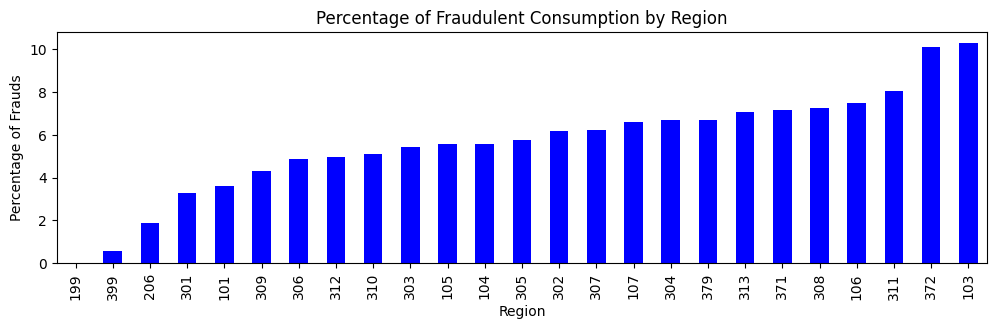

In [ ]:
regionFraudPercent = trainClient.groupby("region")["target"].mean().sort_values() * 100
fig, ax = plt.subplots(figsize=(12, 3))
regionFraudPercent.plot(kind="bar", ax=ax, color="blue")
ax.set_xlabel("Region")
ax.set_ylabel("Percentage of Frauds")
ax.set_title("Percentage of Fraudulent Consumption by Region")

plt.show()


**Observation**

- The plot shows that most regions have a relatively low percentage of frauds, with values ranging between 2% and 8%. However, there are a few regions where the percentage of frauds is significantly higher, such as region 372 and 103, which have values over 10%. On the other hand, some regions, such as region 199, have no frauds reported at all.

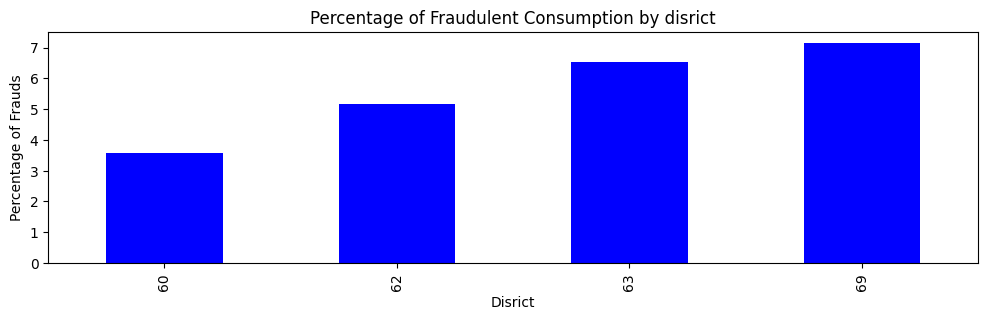

In [ ]:
districtFraudPercent = trainClient.groupby("disrict")["target"].mean() * 100
fig, ax = plt.subplots(figsize=(12, 3))
districtFraudPercent.plot(kind="bar", ax=ax, color="blue")
ax.set_xlabel("Disrict")
ax.set_ylabel("Percentage of Frauds")
ax.set_title("Percentage of Fraudulent Consumption by disrict")
plt.show()

**Observation**

- The plot shows that there is no significant difference in the percentage of frauds across the four districts. District 60 has the lowest percentage of frauds, with 3.5%, followed by district 62 with 5%, district 63 with 6%, and district 29 with 7.1%.

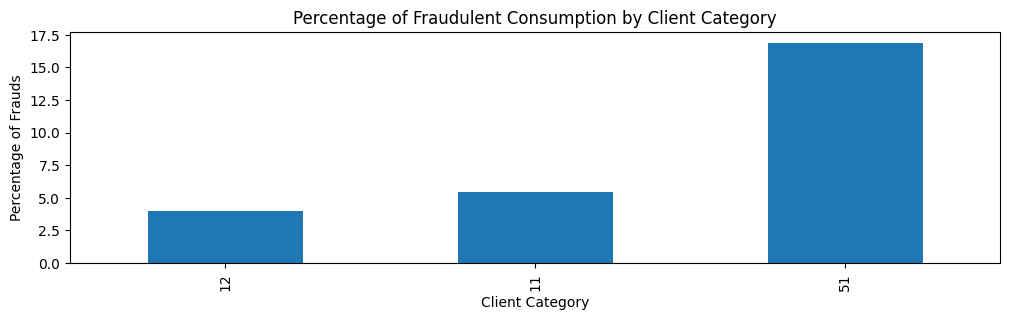

In [ ]:
trainClient['client_catg'] = trainClient['client_catg'].astype(int)
clientCatfraudPercent = trainClient.groupby("client_catg")["target"].mean().sort_values() * 100
fig, ax = plt.subplots(figsize=(12, 3))
clientCatfraudPercent.plot(kind="bar", ax=ax)
ax.set_xlabel("Client Category")
ax.set_ylabel("Percentage of Frauds")
ax.set_title("Percentage of Fraudulent Consumption by Client Category")
plt.show()

**Observation**
- The plot shows that category 51 has the highest percentage of frauds, with over 17%. The other categories have much lower percentages of frauds, with none of the other categories having more than 5% of frauds.

### Merging the data and investigating the users who made fraud

In [ ]:
mergedData = pd.merge(trainClient, trainInvoices, on="client_id")

fraudulentData = mergedData[mergedData["target"] == 1]
nonFraudulentData = mergedData[mergedData["target"] == 0]

In [ ]:
consumptionData = fraudulentData.groupby("invoice_date").agg({"consommation_level_1": "sum", "consommation_level_2": "sum", "consommation_level_3": "sum", "consommation_level_4": "sum"}).reset_index()
consumptionData["invoice_date"] = pd.to_datetime(consumptionData["invoice_date"])
consumptionData.head()

,invoice_date,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4
0,2005-01-07,5006,1986,0,0
1,2005-01-08,4285,577,0,0
2,2005-01-11,34344,2767,0,0
3,2005-01-12,23687,458,0,0
4,2005-02-08,5394,3228,0,0


In [ ]:
invoiceYears = np.unique(consumptionData["invoice_date"].dt.year)
invoiceYears[-3:]

array([2017, 2018, 2019])

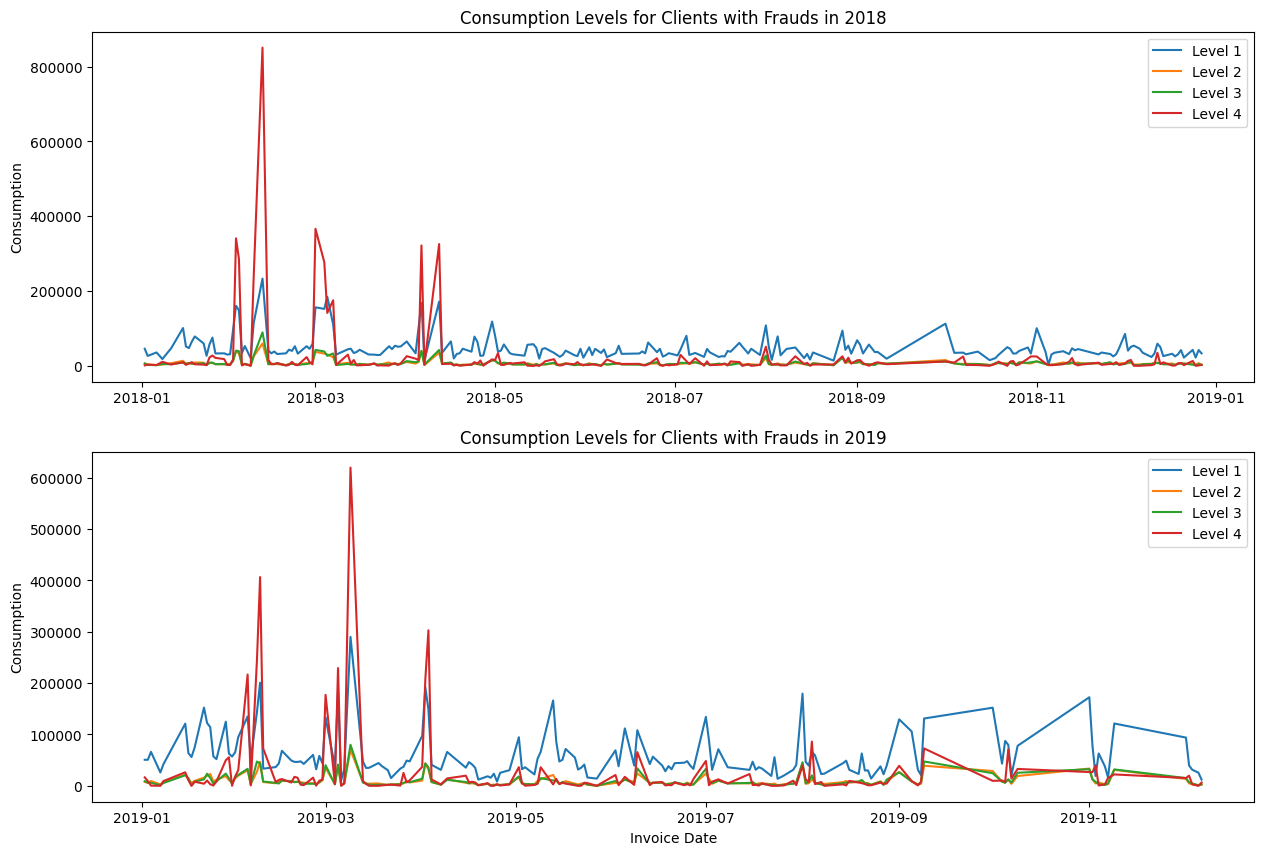

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
for i, year in enumerate(invoiceYears[-2:]):
  ax = axes[i]
  yearlyConsumption = consumptionData[consumptionData["invoice_date"].dt.year == year]
  if not yearlyConsumption.empty:
    ax.plot(yearlyConsumption["invoice_date"], yearlyConsumption["consommation_level_1"], label="Level 1")
    ax.plot(yearlyConsumption["invoice_date"], yearlyConsumption["consommation_level_2"], label="Level 2")
    ax.plot(yearlyConsumption["invoice_date"], yearlyConsumption["consommation_level_3"], label="Level 3")
    ax.plot(yearlyConsumption["invoice_date"], yearlyConsumption["consommation_level_4"], label="Level 4")
    ax.set_ylabel("Consumption")
    ax.set_title(f"Consumption Levels for Clients with Frauds in {year}")
    ax.legend()
ax.set_xlabel("Invoice Date")
plt.show()

In [ ]:
def compareCustomers(year, counterType):
  startDate = f'{year}-01-01'
  endDate = f'{year}-12-31'

  fraudulentData['invoice_date'] = pd.to_datetime(fraudulentData['invoice_date'])
  nonFraudulentData['invoice_date'] = pd.to_datetime(nonFraudulentData['invoice_date'])

  # Select invoices of a fraudulent and a non-fraudulent customer in 2019
  fraudulentClient = fraudulentData[fraudulentData['invoice_date'].dt.year == year].sample(n=1)
  nonFraudulentClient = nonFraudulentData[nonFraudulentData['invoice_date'].dt.year == year].sample(n=1)

  # Calculate the average consumption level 1 for each customer
  fraudAvgConsumpLevel1 = fraudulentData[fraudulentData['client_id'] == fraudulentClient['client_id'].values[0]]['consommation_level_1'].mean()
  nonFraudAvgConsumpLevel1 = nonFraudulentData[nonFraudulentData['client_id'] == nonFraudulentClient['client_id'].values[0]]['consommation_level_1'].mean()

  fraudDataFiltered = fraudulentData[(fraudulentData['counter_type'] == counterType) & (fraudulentData['invoice_date'] >= startDate) & (fraudulentData['invoice_date'] <= endDate)]
  nonFraudDataFiltered = nonFraudulentData[(nonFraudulentData['counter_type'] == counterType) & (nonFraudulentData['invoice_date'] >= startDate) & (nonFraudulentData['invoice_date'] <= endDate)]

  # Calculate the average consumption level 1 for each month in the selected date range for each customer
  fraudulentMonthly = fraudDataFiltered.groupby(pd.Grouper(key='invoice_date', freq='M')).agg({'consommation_level_1': 'mean'}).reset_index()
  fraudulentMonthly['Monthly AVG'] = 'Fraudulent'
  nonFraudulentMonthly = nonFraudDataFiltered.groupby(pd.Grouper(key='invoice_date', freq='M')).agg({'consommation_level_1': 'mean'}).reset_index()
  nonFraudulentMonthly['Monthly AVG'] = 'Non-Fraudulent'

  # Merge the two data frames on the month column
  mergedMonthly = pd.concat([nonFraudulentMonthly,fraudulentMonthly])

  # Plot the consumption discrepancy between the two customers
  fig = px.line(mergedMonthly, x='invoice_date', y='consommation_level_1', color='Monthly AVG',
                line_dash='Monthly AVG', markers=True, template='plotly_white')
  fig.update_layout(title=f'Consumption Discrepancy Comparison Between Two Selected Customers ({year})')
  fig.show()

In [ ]:
compareCustomers(year = 2019,
                 counterType = "ELEC")

In [ ]:
compareCustomers(year = 2017,
                 counterType = "GAZ")

**Observation**

- The plot displays the average `consumption level 1` for two randomly selected customers, `one fraudulent` and `one non-fradulent`.
- The blue line represents the `non-fraudulent customer`, while the red line represents the `fraudulent customer`. The `non-fraudulent customer` has a relatively `stable` consumption pattern, with only slight fluctuations over time, whereas the `fraudulent customer` is `slightly unstable` with frequent spikes and dips in consumption. 


## **Data Preprocessing and Feature Engineering**

In [ ]:
def dateTimeFeatures(clients, invoices):
  """
  clients: The dataframe containing the clients information
  invoices: The dataframe containing the clients invoices information
  """
  for dateCol, df in [('invoice_date', invoices), ('creation_date', clients)]:
    df[dateCol] = df[dateCol].astype('datetime64[ns]')
    df[f'{dateCol}_Date_Int'] = df[dateCol].astype(np.int64) * 1e-9
    df[f'{dateCol}_Day'] = df[dateCol].dt.day
    df[f'{dateCol}_Month'] = df[dateCol].dt.month
    df[f'{dateCol}_Year'] = df[dateCol].dt.year

    #if dateCol == 'invoice_date':
      #df['is_weekday'] = ((df[dateCol].dt.dayofweek) // 5 == 1).astype(float) 
    if dateCol == 'creation_date':
      df['creationMonths'] = (2019 - df[f'{dateCol}_Year'])*12 - df[f'{dateCol}_Month'] #2022

    df.drop(dateCol, inplace=True,  axis=1)
    
  invoices = reduce_memory_usage(invoices)

  return clients, invoices

In [ ]:
def formatFeatures(clients, invoices):
  
  ## regionGroup: Dividing 'region' in 3 groups
  clients['regionGroup'] = clients['region'].apply(lambda x: 1 if x<100 else 3 if x>300 else 2)

  mapper = {0:0,1:1,2:2,3:3,4:4,5:5,
             '0':0,'1':1,'2':2,'3':3,'4':4,'5':5,
             769:5,'A':0,618:5,269375:5,
             46:5, 420:5}

  ## Clean data
  invoices['counter_statue'] = invoices['counter_statue'].map(mapper)
  invoices['counter_statue'] = invoices['counter_statue'].astype(str)
  ## Invoice date-time features
  invoices['delta_index'] = invoices['new_index'] - invoices['old_index']
    
  return clients, invoices

In [ ]:
def featureInteraction(invoices):
  invoices['FI_add'] = invoices['counter_code'] + invoices['counter_number'] 
  invoices['FI_sub'] = invoices['counter_code'] - invoices['counter_number'] 
  invoices['FI_prod'] = invoices['counter_code'] * invoices['counter_number'] 
  invoices['FI_div'] = invoices['counter_code'] / invoices['counter_number'] 

  return invoices

In [ ]:
def featAggregation(clients, invoices, catFeat, numFeat):
  features = catFeat + numFeat
  for feat in features:
    clients[f'{feat}_AggMean'] = clients['client_id'].map(dict(invoices.groupby('client_id')[feat].mean()))
    clients[f'{feat}_AggMedian'] = clients['client_id'].map(dict(invoices.groupby('client_id')[feat].median()))
    clients[f'{feat}_AggStd'] = clients['client_id'].map(dict(invoices.groupby('client_id')[feat].std()))
    clients[f'{feat}_AggMin'] = clients['client_id'].map(dict(invoices.groupby('client_id')[feat].min()))
    clients[f'{feat}_AggMax'] = clients['client_id'].map(dict(invoices.groupby('client_id')[feat].max()))
    clients[f'{feat}_AggSum'] = clients['client_id'].map(dict(invoices.groupby('client_id')[feat].sum()))
    clients[f'{feat}_AggRange'] = clients[f'{feat}_AggMax'] - clients[f'{feat}_AggMin']  

  for feat in catFeat:
    clients[f'{feat}_AggMode'] = clients['client_id'].map(dict(invoices.groupby('client_id')[feat].agg(lambda x: pd.Series.mode(x)[0])))
    clients[f'{feat}_AggNunique'] = clients['client_id'].map(dict(invoices.groupby('client_id')[feat].nunique()))

  return clients

In [ ]:
class ProcessData:

  def LE(self, df, train, test, LE_cols = []) :
    LE = LabelEncoder()
    for le_col in LE_cols :
      LE.fit_transform(df[le_col])
      train[le_col] = LE.transform(train[le_col])
      test[le_col] = LE.transform(test[le_col])
  
  def process(self):
    testInvoices = pd.read_csv(f'{path}test/invoice_test.csv',low_memory=False)
    trainInvoices = pd.read_csv(f'{path}train/invoice_train.csv',low_memory=False)
    testClient = pd.read_csv(f'{path}test/client_test.csv',low_memory=False)
    trainClient = pd.read_csv(f'{path}train/client_train.csv',low_memory=False)
    
    trainInvoices = trainInvoices.sort_values(['client_id','invoice_date']).reset_index(drop=True) 
    testInvoices = testInvoices.sort_values(['client_id','invoice_date']).reset_index(drop=True)
    trainClient['target'] = trainClient['target'].astype(int)
    ##########################################################

    trainClient, trainInvoices = dateTimeFeatures(clients = trainClient,
                                                  invoices = trainInvoices)
    
    testClient, testInvoices = dateTimeFeatures(clients = testClient,
                                                invoices = testInvoices)

    trainClient, trainInvoices = formatFeatures(clients = trainClient,
                                                  invoices = trainInvoices)
    
    testClient, testInvoices = formatFeatures(clients = testClient,
                                                invoices = testInvoices)
    
    ##############################################
    testID = testClient['client_id']

    trainInvoices = featureInteraction(invoices = trainInvoices)
    testInvoices = featureInteraction(invoices = testInvoices)

    ##########################################################

    numericAggFeat = ['consommation_level_1','consommation_level_2','consommation_level_3',
                'consommation_level_4','months_number','FI_add', 'FI_sub','FI_prod','FI_div']
                
    CategoricalAggFeat = ['reading_remarque','counter_coefficient','tarif_type',
                'counter_number','counter_statue','counter_code',
                'old_index','new_index','counter_type','invoice_date_Date_Int',
                'invoice_date_Day','invoice_date_Month','invoice_date_Year','delta_index']

    # Label Encoder 
    combinedDf = pd.concat([trainInvoices, testInvoices])
    self.LE(combinedDf, trainInvoices, testInvoices, LE_cols = CategoricalAggFeat)

    ## Features Aggregation
    trainClient = featAggregation(clients = trainClient,
                                  invoices = trainInvoices, 
                                  catFeat = CategoricalAggFeat,
                                  numFeat = numericAggFeat)
    
    testClient = featAggregation(clients = testClient,
                                  invoices = testInvoices, 
                                  catFeat = CategoricalAggFeat,
                                  numFeat = numericAggFeat)
    
    # Dropping the ID column
    trainClient.drop('client_id',inplace=True,axis=1)
    testClient.drop('client_id',inplace=True,axis=1)

    # Label Encoder 2
    CategoricalFeats = list(trainClient.select_dtypes(include=['object','category']).columns)
    combinedDf = pd.concat([trainInvoices, testInvoices])
    self.LE(combinedDf, trainInvoices, testInvoices, LE_cols = CategoricalFeats)

    # OHE Encoder
    oheFeatures = ['region','disrict']
    combinedDf = pd.concat([trainClient, testClient])
    for feat in oheFeatures:
      featNames = [f'{feat}_{x}' for x in combinedDf[feat].value_counts().keys().sort_values()]
      oheDf = pd.DataFrame(pd.get_dummies(combinedDf[feat]).values, index = combinedDf.index, columns = featNames)
      combinedDf = pd.concat([combinedDf , oheDf],axis=1)
        
    trainClient = combinedDf[:trainClient.shape[0]]
    testClient = combinedDf[trainClient.shape[0]:]
    testClient.drop('target', inplace=True, axis=1)

    return trainClient, testClient, testID

In [ ]:
processor = ProcessData()
trainClient, testClient, testID = processor.process()

In [ ]:
trainClient.shape, testClient.shape

In [ ]:
trainClientCopy, testClientCopy = trainClient.copy(), testClient.copy()

In [ ]:
trainClient.fillna(-99999999, inplace=True) 
testClient.fillna(-99999999, inplace=True)

In [ ]:
cols = trainClient.columns
dup = []
for feat_1 in tqdm(cols):
  if (feat_1 in dup):
    continue
  for feat_2 in cols.drop(feat_1):
    if (feat_2 in dup):
      continue
    if (trainClient[feat_1].equals(trainClient[feat_2])):
      trainClient.drop(feat_2,inplace=True,axis=1)
      testClient.drop(feat_2,inplace=True,axis=1)
      dup.append(feat_2)

#Drop Constant Features
for feat in tqdm(testClient.columns):
  if ((len(trainClient[feat].value_counts().keys()) == 1) | (len(testClient[feat].value_counts().keys()) == 1)):
    trainClient.drop(feat,inplace=True,axis=1)
    testClient.drop(feat,inplace=True,axis=1)
        
print('Features After Dropping: ', trainClient.shape)

In [ ]:
trainClient.isnull().sum().sum(), testClient.isnull().sum().sum()

In [ ]:
# trainClient = trainClient.fillna(trainClient.median())
# testClient = testClient.fillna(testClient.median())

In [ ]:
trainClient.isnull().sum().sum(), testClient.isnull().sum().sum()

## **Modelling**

In [ ]:
dropCol = ['counter_coefficient_AggRange', 'counter_coefficient_AggMean',
       'counter_type_AggRange', 'region_399',
       'counter_coefficient_AggMedian', 'counter_type_AggMin',
       'counter_coefficient_AggMin', 'counter_coefficient_AggMax',
       'counter_coefficient_AggNunique', 'region_206',
       'counter_coefficient_AggMode']

X = trainClient.drop(dropCol+['target'],axis=1)
y = trainClient['target']

X_test = testClient.drop(dropCol,axis=1)

In [ ]:
class CFG:
  seed = 42 #42, 47
  n_splits = 5
  lgbParams = {"n_estimators":830, "num_leaves":454, "max_depth":61,"scale_pos_weight":2.5,
              "learning_rate":0.006910869038433314, "min_split_gain":0.00667926424629105, 
              "feature_fraction":0.3764303138879782, "bagging_freq":8}

fold = StratifiedKFold(n_splits=CFG.n_splits)#shuffle=True, random_state = CFG.seed

### **LightGBM**

In [ ]:
def evalerror(preds, dtrain):
  labels = dtrain.get_label()
  return 'log_loss', log_loss(labels, preds), True

In [ ]:
predictedProbs = pd.DataFrame()
trainPredict = np.zeros((X.shape[0],))
aucScores = []

for i, (trainIdx, valIdx) in enumerate(fold.split(X, y)):
  X_train, X_valid = X.iloc[trainIdx], X.iloc[valIdx]
  y_train, y_valid = y[trainIdx], y[valIdx]

  print(50*'-')
  print(f'Fold {i+1} / {CFG.n_splits}' )

  model = LGBMClassifier(**CFG.lgbParams2,
                         random_state= CFG.seed)

  model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=30, verbose=False)
        
  preds = model.predict_proba(X_valid)[:,1]
  testPredict = model.predict_proba(X_test)
  trainPredict[valIdx] = preds
  aucScores.append(roc_auc_score(y_valid, preds))
  print(f'FOLD-{i} AUC score :', roc_auc_score(y_valid, preds))
  predictedProbs[f'fold_{i}'] = testPredict[:,1]
  print(50*'-')


print('Average AUC score :', np.mean(aucScores))
print('AUC score STD:', np.std(aucScores))
print('Train AUC score :', roc_auc_score(y, trainPredict))
print('Test AUC score :', roc_auc_score([1 if x > 0.5 else 0 for x in predictedProbs.mean(1)], predictedProbs.mean(1)))

--------------------------------------------------
Fold 1 / 5
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
FOLD-0 AUC score : 0.896273309991848
--------------------------------------------------
--------------------------------------------------
Fold 2 / 5
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
FOLD-1 AUC score : 0.901861813164203
--------------------------------------------------
--------------------------------------------------
Fold 3 / 5
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current val

In [ ]:
modelLGBM = LGBMClassifier(**CFG.lgbParams,
                         random_state= CFG.seed)
modelLGBM.fit(X, y)

testPredictLGBM = modelLGBM.predict_proba(X_test)

submission = pd.DataFrame({
        "client_id": testID,
        "target":testPredictLGBM 
    })
submission.to_csv('Solution[LightGbm_SPOS_2.5].csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


In [ ]:
# def strategicBlend(df, rate = 0.1):
#   bestBlend = []
#   bestAverage = 0
#   bestRates = []
#   n = 1
#   for r in  range(0,1.001, rate):
#     weight1 = r
#     weight2 = 1 - r
#     fScore = roc_auc_score(df["target"], weight1*df["pred1"] + weight2*df["pred2"])
#     scores = []
#     for i, (trainIdx, valIdx) in enumerate(fold.split(df, df["target"])):
#       sample = df.iloc[valIdx]
#       tScore = roc_auc_score(sample["target"], weight1*sample["pred1"] + weight2*sample["pred2"])
#       scores.append(tScore)

#     avgScores = np.mean(scores)
#     stdScores = np.std(scores)
#     if avgScores > bestAverage:
#       bestAverage = avgScores
#       bestRates = [weight1, weight2]

#     printStr = f"[Trial {n}]: weigths: [{weight1}, {weight2}], DataEval : {fScore}, Average ===> {avgScores} +/- {stdScores}"

#     n+=1

#   return f"Best Rates: {bestRates}"

**Happy Learning :-)**